In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

### Classical Fourier Transform
Maps a vector $\mathbf{x}$ to the vector $\mathbf{y}$
$$[x_0, \dots, x_n] \leftrightarrow	[y_0, \dots, y_n]$$
#### Discrete FT
$$y_k = \sum_{j=0}^{N-1} x_j e^{-i\frac{2 \pi jk}{N}}$$
#### Inverse Discrete FT
$$x_k = \frac{1}{N} \sum_{j=0}^{N-1} y_j e^{i \frac{2 \pi jk}{N}}$$

In [2]:
def _performBaseDiscreteFT(X: np.array, angle_base: float, N: int):
    """ Base operations for DFT """
    return np.array([np.sum([X[j] * np.exp(angle_base * j * k) for j in range(N)]) for k in range(N)])

def performDiscreteFT(X: np.array):
    """ Performs Discrete Fourier Transform on X """
    N = len(X)
    angle_base = -1j * 2 * np.pi / N
    return _performBaseDiscreteFT(X, angle_base, N)

def inverseDiscreteFT(X: np.array):
    """ Performs Inverse Discrete Fourier Transform on X """
    N = len(X)
    angle_base = 1j * 2 * np.pi / N
    return 1 / N * _performBaseDiscreteFT(X, angle_base, N)

In [3]:
x = np.array([8, 4, 8, 0])
print("Input data:            {}".format(x))
y = performDiscreteFT(x)
print("Data in Fourier space: {}".format(np.round(y, 2)))
x_back = inverseDiscreteFT(y)
print("Transfering back:      {}".format(np.round(x_back, 2)))

Input data:            [8 4 8 0]
Data in Fourier space: [20.+0.j  0.-4.j 12.+0.j -0.+4.j]
Transfering back:      [8.-0.j 4.-0.j 8.+0.j 0.+0.j]


### Quantum Fourier Transform
Maps a quantum state $\sum_{j=0}^{N-1} y_j\lvert j\rangle$ to the quantum state $\sum_{k=0}^{N-1} x_k \lvert k\rangle$

$$\lvert j \rangle = \frac{1}{\sqrt N} \sum_{k=0}^{N-1} e^{i\frac{ 2 \pi jk}{N}} \lvert k \rangle$$

where $\lvert 0 \rangle, \dots, \lvert N-1 \rangle$ is an orthonormal basis. The QFT transforms between computational and Fourier basis.

#### Computational basis for $n$-qubit computer
$\lvert j \rangle = \lvert j_1 j_2 \dots j_n\rangle$, where $j = j_1 2^{n-1} + j_2 2^{n-2} + \dots + j_n 2^0$

We can therefore rewrite it like:
$$\lvert j \rangle = \frac{1}{\sqrt{2^n}}
\left(\lvert 0 \rangle + e^{i \frac{2\pi j}{2}} \lvert 1\rangle\right) \otimes
\left(\lvert 0 \rangle + e^{i \frac{2\pi j}{2^2}} \lvert 1 \rangle\right) \otimes  
\ldots
\otimes \left(\lvert 0 \rangle + e^{i \frac{2\pi j}{2^n}} \lvert 1 \rangle\right) $$

In [4]:
def addQFTCircuit(circuit, n_qubits):
    """ Add QFT gates to existing circuit """
    
    for current_qubit in range(n_qubits - 1, -1, -1):
        circuit.h(current_qubit)
        for control_qubit in range(current_qubit):
            circuit.cu1(np.pi / 2 ** (current_qubit - control_qubit), control_qubit, current_qubit)
    
    swap_indecies = np.arange(0, n_qubits // 2)
    circuit.swap(list(swap_indecies), list(n_qubits - 1 - swap_indecies))
    
    return circuit

#### Basic QFT circuit

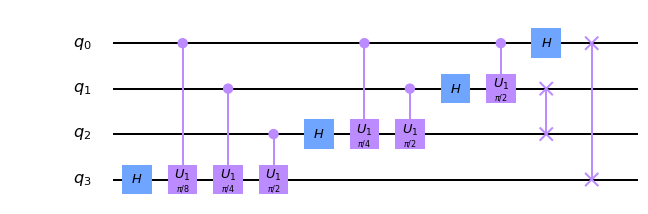

In [5]:
n_qubits = 4
circuit = QuantumCircuit(n_qubits)
circuit = addQFTCircuit(circuit, n_qubits)

circuit.draw()

#### Let's give it a try. 
Encoding '10' in computational basis (The qubits are initially prepared in $\lvert 0 \rangle$).

Binary representation of 10:   0b1010
Which translates to the following circuit:


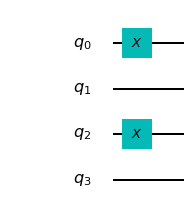

In [6]:
print("Binary representation of 10:   {}".format(bin(10)))
print("Which translates to the following circuit:")

circuit = QuantumCircuit(n_qubits)

circuit.x(0)
circuit.x(2)

circuit.draw()

Number '10' in computational basis:

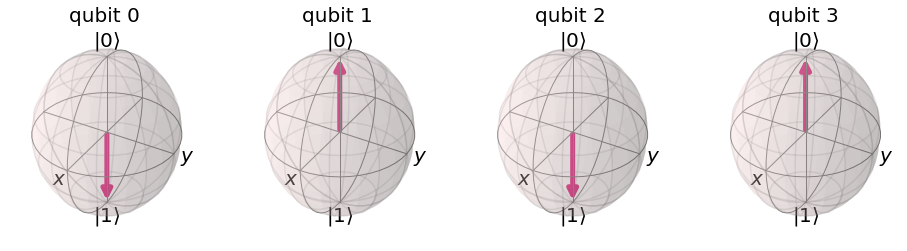

In [7]:
# Running on a simulator
state_simulator = Aer.get_backend("statevector_simulator")

state_vector = execute(circuit, backend=state_simulator).result().get_statevector()
plot_bloch_multivector(state_vector)

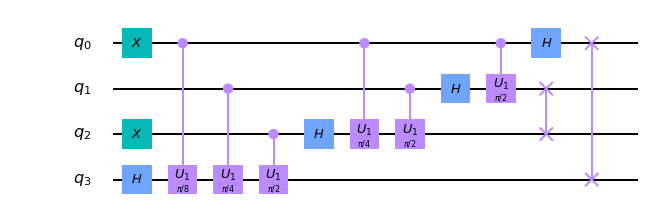

In [8]:
# Applying QFT to the circut
circuit = addQFTCircuit(circuit, n_qubits)
circuit.draw()

Number '10' in Fourier basis visualisation:

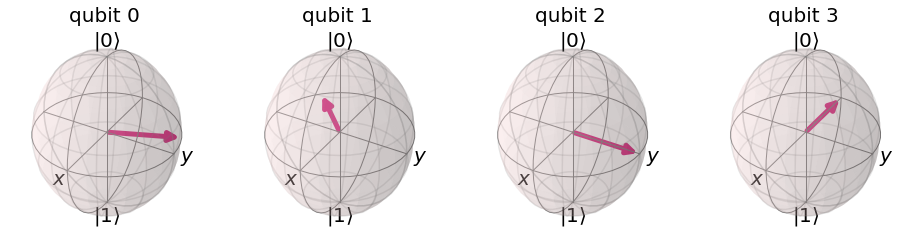

In [9]:
state_vector = execute(circuit, backend=state_simulator).result().get_statevector()
plot_bloch_multivector(state_vector)

#### Let's verify this result 

Input vector: $\lvert x_3 x_2 x_1 x_0 \rangle = \lvert 1 0 1 0\rangle$

---
##### $\lvert x_0 \rangle$ qubit transform:
1. Applying Hadamard gate on $\lvert x_0 \rangle$:
$$ \lvert x_0 \rangle= \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{2 \pi}{2^1} x_0) \lvert 1 \rangle \big]  = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \lvert 1 \rangle \big] = $$
2. Applying rotation gate on $\lvert x_0 \rangle$ controlled by $\lvert x_1 \rangle$:
$$ = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{2 \pi}{2^2} x_1) \lvert 1 \rangle \big] = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{\pi}{2}) \lvert 1 \rangle \big] = $$
3. Applying rotation gate on $\lvert x_0 \rangle$ controlled by $\lvert x_2 \rangle$:
$$ = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{\pi}{2} + i\frac{2 \pi}{2^3} x_2) \lvert 1 \rangle \big] = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{\pi}{2}) \lvert 1 \rangle \big] $$
4. Applying rotation gate on $\lvert x_0 \rangle$ controlled by $\lvert x_3 \rangle$:
$$ = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{\pi}{2} + i\frac{2 \pi}{2^4} x_3) \lvert 1 \rangle \big] = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{5 \pi}{8}) \lvert 1 \rangle \big] $$
---
##### $\lvert x_1 \rangle$ qubit transform:
1. Applying Hadamard gate on $\lvert x_1 \rangle$:
$$ \lvert x_1 \rangle= \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{2 \pi}{2^1} x_1) \lvert 1 \rangle \big]  = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i \pi) \lvert 1 \rangle \big] = $$
2. Applying rotation gate on $\lvert x_1 \rangle$ controlled by $\lvert x_2 \rangle$:
$$ = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i \pi + i\frac{2 \pi}{2^2} x_2) \lvert 1 \rangle \big] = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i \pi) \lvert 1 \rangle \big] = $$
3. Applying rotation gate on $\lvert x_1 \rangle$ controlled by $\lvert x_3 \rangle$:
$$ = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i \pi + i\frac{2 \pi}{2^3} x_3) \lvert 1 \rangle \big] = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{5 \pi}{4}) \lvert 1 \rangle \big] $$
---

Transfer into $\lvert + \rangle$ basis by applyting Hadamard gate and rotate around $Z$ by $\frac{5 \pi}{4}$

---
##### $\lvert x_2 \rangle$ qubit transform:
1. Applying Hadamard gate on $\lvert x_2 \rangle$:
$$ \lvert x_2 \rangle= \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{2 \pi}{2^1} x_2) \lvert 1 \rangle \big]  = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle +  \lvert 1 \rangle \big] = $$
2. Applying rotation gate on $\lvert x_2 \rangle$ controlled by $\lvert x_3 \rangle$:
$$ = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{2 \pi}{2^2} x_3) \lvert 1 \rangle \big] = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{\pi}{2}) \lvert 1 \rangle \big]$$
---
Transfer into $\lvert + \rangle$ basis by applyting Hadamard gate and rotate around $Z$ by $\frac{\pi}{2}$

---
##### $\lvert x_3 \rangle$ qubit transform:
1. Applying Hadamard gate on $\lvert x_3 \rangle$:
$$ \lvert x_3 \rangle= \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i\frac{2 \pi}{2^1} x_3) \lvert 1 \rangle \big]  = \frac{1}{\sqrt{2}}\big[ \lvert 0 \rangle + \exp(i \pi) \lvert 1 \rangle \big]$$
---
Transfer into $\lvert + \rangle$ basis by applyting Hadamard gate and rotate around $Z$ by $\pi$

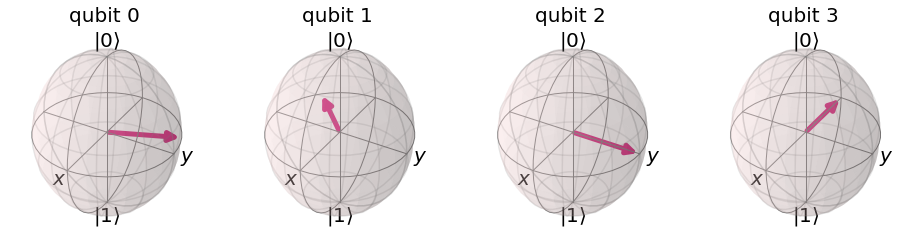

In [23]:
# Constructing a circuit based on results above
circuit_test = QuantumCircuit(n_qubits)

circuit_test.h([q for q in range(n_qubits)])

circuit_test.u1(5 * np.pi / 8, 0)
circuit_test.u1(5 * np.pi / 4, 1)
circuit_test.u1(np.pi / 2, 2)
circuit_test.u1(np.pi, 3)

state_vector = execute(circuit_test, backend=state_simulator).result().get_statevector()
plot_bloch_multivector(state_vector)

### Inverse Quantum Fourier Transform

In [11]:
def addInverseQFTCircuit(circuit, n_qubits):
    """ Add Inverse QFT gate to the circuit """
    circuit_qft = QuantumCircuit(n_qubits)
    circuit_qft = addQFTCircuit(circuit_qft, n_qubits)
    circuit.append(circuit_qft.inverse(), circuit_qft.qubits[:n_qubits])
    return circuit.decompose()

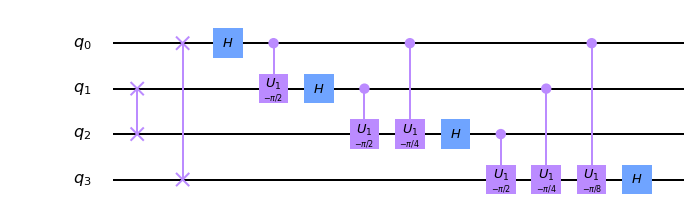

In [24]:
circuit_inverse = QuantumCircuit(n_qubits)
circuit_inverse = addInverseQFTCircuit(circuit_inverse, n_qubits)

circuit_inverse.draw()

#### Applying Inverse QFT on the qubits transfered into Fourier basis

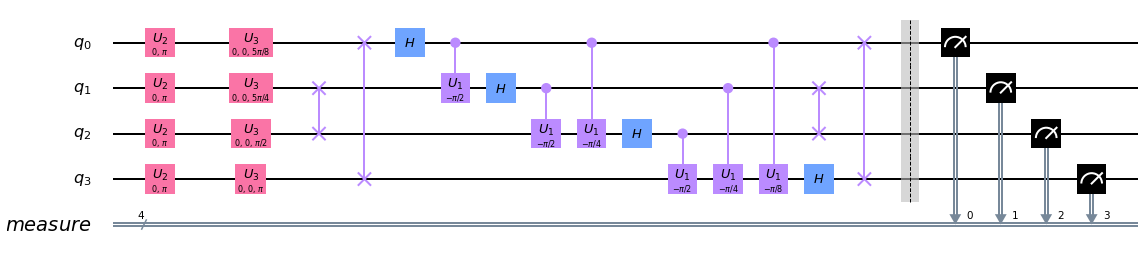

In [25]:
circuit_inverse = addInverseQFTCircuit(circuit_test, n_qubits)
swap_indecies = np.arange(0, n_qubits // 2)
circuit_inverse.swap(list(swap_indecies), list(n_qubits - 1 - swap_indecies))

circuit_inverse.measure_all()

circuit_inverse.draw()

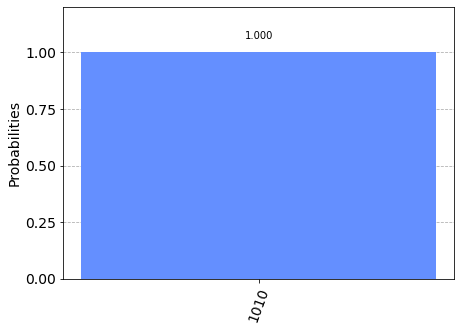

In [29]:
# Running on a simulator
simulator = Aer.get_backend('qasm_simulator')

job = execute(circuit_inverse, simulator, shots = 1000)
result = job.result().get_counts()

plot_histogram(result)

In [30]:
# Running on real quantum computer
backend = least_busy(
    provider.backends(
        filters=lambda x: x.configuration().n_qubits >= n_qubits 
        and not x.configuration().simulator 
        and x.status().operational==True
    )
)
print("Least busy quantum computer: {}".format(backend))

Least busy quantum computer: ibmq_essex


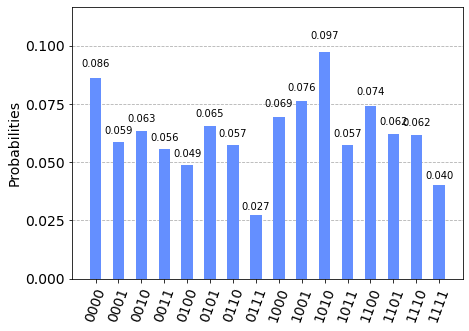

In [33]:
job = execute(circuit_inverse, backend=backend, shots=2048, optimization_level=3)
plot_histogram(job.result().get_counts())

### Literature:

1. Abraham Asfaw et al., Learn Quantum Computation Using Qiskit, 2020, https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html
2. M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, 10th Anniversary Edition, Cambridge University Press, Cambridge, 2010
3. University of Oxford, Signal Processing & Filter Design Course, Lecture slides: The discrete Fourier transform 